- encoding - https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63

# Data Cleaning

Based on the conclusions formed during exploratory data analysis, we have a better idea of the dataset we are dealing with. We can further clean and refine the data.

In [23]:
# import all libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

In [24]:
# load the original data
data = pd.read_csv('dataset_original.csv')

In [25]:
# sneak peak into the original data
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


We can drop the id column since it has no affect on the target variable

In [26]:
# dropping the id column
data.drop('id', axis=1, inplace=True)

data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


We have 10 independant features and 1 dependant feature --> **Stroke**

## Outlier removal

We will remove the outlier datapoints that might be there because of human error or other factors. We will use Using 1.5 IQR rule (read and write about it in the thesis)

In [28]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

features_list = list()
for col in data.select_dtypes(exclude='object'):
    features_list.append(col)

data.loc[detect_outliers(data, features_list)]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
17,Male,75.0,1,0,Yes,Private,Urban,221.29,25.8,smokes,1
21,Female,52.0,1,0,Yes,Self-employed,Urban,233.29,48.9,never smoked,1
30,Male,57.0,1,0,Yes,Private,Urban,212.08,44.2,smokes,1
...,...,...,...,...,...,...,...,...,...,...,...
155,Female,77.0,0,1,Yes,Private,Rural,231.56,36.9,never smoked,1
189,Male,61.0,0,1,Yes,Private,Urban,209.86,NaN,Unknown,1
215,Female,79.0,0,1,No,Private,Urban,205.33,31.0,smokes,1
219,Male,73.0,0,1,Yes,Govt_job,Rural,219.73,28.6,never smoked,1


In [29]:
# drop outliers
data = data.drop(detect_outliers(data, features_list))

In [30]:
data.shape

(5035, 11)

As we can see we removed 75 entries from our dataset

In [34]:
data = data.reset_index(drop=True)

data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
4,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5030,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5031,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5032,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5033,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## Missing values

Our dataset might have some NaN or missing values

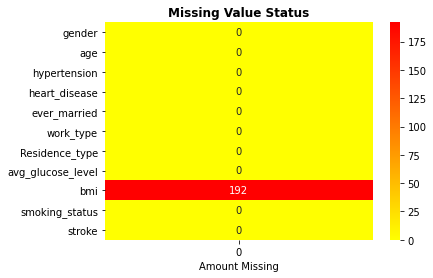

In [35]:
plt.title('Missing Value Status',fontweight='bold')
ax = sns.heatmap(data.isna().sum().to_frame(),annot=True,fmt='d',cmap='autumn_r')
ax.set_xlabel('Amount Missing')
plt.show()

We can see we have 192 entries for bmi which are NaN

## Imputing the Missing Data

We will replace the missing data values with substituted values. There can be many approaches to this (https://towardsdatascience.com/handling-missing-data-12ac7c59eebc)
- Mean
- Mode
- Interpolation
- K-nearest neighbour imputer

(read on them in the article, expand on in thesis) We will use KNNImputer

- From the correlation matrix from exploratory data anaysis we can say that bmi is dependant on age and also gender
- We will need to use label encoding on the gender attribute so as to convert it to an int datatype.
- we also need to apply feature scaling on our data since knn is a distance based algorithm, and features on different scales will skew the output

In [36]:
# label encoding

# make a copy of dataset
data_copy = data[['bmi', 'age', 'gender']]

# label encoding on gender, replace Female with 0, Male with 1 and Other with 2
data_copy['gender'] = data_copy['gender'].replace({'Female':0, 'Male':1, 'Other':2}).astype(int)

/var/folders/48/8f9nt6w53xd9t8kncfsjxq9c0000gn/T/ipykernel_89482/2407329423.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_copy['gender'] = data_copy['gender'].replace({'Female':0, 'Male':1, 'Other':2}).astype(int)


In [37]:
data_copy.head(3)

,bmi,age,gender
0,NaN,61.0,0
1,32.5,80.0,1
2,34.4,49.0,0


In [38]:
# Feature scaling, we will use min max scalar

scaler = MinMaxScaler()
data_copy = pd.DataFrame(scaler.fit_transform(data_copy), columns = data_copy.columns)

data_copy.head()

,bmi,age,gender
0,NaN,0.743652,0.0
1,0.254296,0.975586,0.5
2,0.276060,0.597168,0.0
3,0.214204,0.987793,0.5
4,0.143184,0.841309,0.0


In [39]:
# Now we are ready to apply KNNImpute
knn_imputer = KNNImputer(n_neighbors=2)
data_copy = knn_imputer.fit_transform(data_copy)

In [40]:
# convert this numpy array into a pandas dataframe
column_list = ['bmi', 'age', 'gender']
data_copy = pd.DataFrame(data_copy, columns = column_list)

In [41]:
data_copy

,bmi,age,gender
0,0.228522,0.743652,0.0
1,0.254296,0.975586,0.5
2,0.276060,0.597168,0.0
3,0.214204,0.987793,0.5
4,0.143184,0.841309,0.0
...,...,...,...
5030,0.159221,0.975586,0.0
5031,0.340206,0.987793,0.0
5032,0.232532,0.426270,0.0
5033,0.175258,0.621582,0.5


In [42]:
# Now we can replace the old bmi column with this new bmi column
data = data.assign(bmi=data_copy['bmi'])

data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,0.228522,never smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,0.254296,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,0.276060,smokes,1
3,Male,81.0,0,0,Yes,Private,Urban,186.21,0.214204,formerly smoked,1
4,Female,69.0,0,0,No,Private,Urban,94.39,0.143184,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5030,Female,80.0,1,0,Yes,Private,Urban,83.75,0.159221,never smoked,0
5031,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,0.340206,never smoked,0
5032,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,0.232532,never smoked,0
5033,Male,51.0,0,0,Yes,Private,Rural,166.29,0.175258,formerly smoked,0


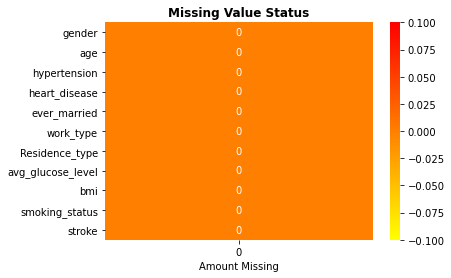

In [43]:
# Check for missing values again
plt.title('Missing Value Status',fontweight='bold')
ax = sns.heatmap(data.isna().sum().to_frame(),annot=True,fmt='d',cmap='autumn_r')
ax.set_xlabel('Amount Missing')
plt.show()

As we can see our data contains no missing values